In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.loss import MSELoss
torch.manual_seed(123)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = os.path.join('/content/drive', 'My Drive', 'AFL', 'stats.csv')
data = pd.read_csv(data_path)
# data = data.fillna(0)

In [ ]:
print(data.columns)

Index(['Team', 'Player', 'D.O.B', 'Height', 'Weight', 'Position', 'Season',
       'Round', 'Date', 'Score', 'Margin', 'WinLoss', 'Opposition', 'Venue',
       'Disposals', 'Kicks', 'Marks', 'Handballs', 'Goals', 'Behinds',
       'Hitouts', 'Tackles', 'Rebound50s', 'Inside50s', 'Clearances',
       'Clangers', 'FreesFor', 'FreesAgainst', 'BrownlowVotes',
       'ContendedPossessions', 'UncontendedPossessions', 'ContestedMarks',
       'MarksInside50', 'OnePercenters', 'Bounces', 'GoalAssists',
       'PercentPlayed'],
      dtype='object')


In [ ]:
rounds = 23
round_key = {'R' + f"{i+1}": i for i in range(rounds)}
data['Round'] = data['Round'].replace(round_key) #test
print(data['Round'].unique())

[0 1 2 3 4 5 6 7 8 9 10 11 12 14 15 16 17 18 19 20 21 22 13 'QF' 'SF' 'PF'
 'GF' 'EF']


In [ ]:
g1 = data.groupby(by = ['Player', 'Season'])

x_labels = ['Disposals', 'Kicks', 'Marks', 'Handballs', 'Goals', 'Behinds',
       'Hitouts', 'Tackles', 'Rebound50s', 'Inside50s', 'Clearances',
       'Clangers', 'FreesFor', 'FreesAgainst', 
       'ContendedPossessions', 'UncontendedPossessions', 'ContestedMarks',
       'MarksInside50', 'OnePercenters', 'Bounces', 'GoalAssists',
       'PercentPlayed'] #'Margin', 'WinLoss', 'Opposition', 'Venue',
       
y_labels = 'BrownlowVotes'

In [ ]:
def transform_data(df: pd.core.frame.DataFrame, x_labels: list = x_labels):

  # global x_labels
  global rounds

  output = pd.DataFrame(index=range(rounds), columns=x_labels)
  output.loc[:,:] = 0

  for i in range(rounds):
    if (df['Round'] == i).any():
      output.loc[[i]] = df[df['Round'] == i][x_labels].values.tolist()
  return output

In [ ]:
X = []
Y = []

for df in tqdm(g1):
  Y.append(df[1]['BrownlowVotes'].agg(sum))
  X.append(transform_data(df[1]).values.flatten())


100%|██████████| 4651/4651 [02:15<00:00, 34.43it/s]


In [ ]:
X[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
X,Y = torch.tensor(X, dtype=torch.float),torch.tensor(Y,dtype=torch.float)
# Y = Y.type(torch.LongTensor)

In [ ]:
# Build a class for the neural network 
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    self.hidden1 = nn.Sequential(nn.Linear(X.shape[1], 100), 
                               nn.ReLU())
    
    self.hidden2 = nn.Sequential(nn.Linear(100,50), 
                               nn.ReLU())

    self.output = nn.Linear(50, 1)

  def forward(self,x):
    x = self.hidden1(x)

    x = self.hidden2(x)

    x = self.output(x)

    return x

In [ ]:
MLP_loss = []

def train(X = X,
          Y = Y,    
          loss_function=nn.MSELoss(),
          epoch_num = 150,  
          batch_size= 100,
          lr=0.0001,):
  

  network = Net()

  data_tuple = [[X[i], Y[i]] for i in range(len(X))] #accuracy 

  batch = torch.utils.data.DataLoader(data_tuple, 
                                      batch_size=batch_size, 
                                      shuffle=True)
  
  optimizer = optim.Adam(network.parameters(), 
                         lr=lr,
                         betas=(0.9, 0.999))

  for epoch in range(epoch_num):

    if not epoch % 10:
      print("Iteration: ", epoch , "Completion: ", (epoch)/epoch_num)

    running_loss = 0
    
    for batch_shuffle in batch:
      
      x,y = batch_shuffle
      y = y.unsqueeze(1)
      # print(x.shape)

      #Give loss
      optimizer.zero_grad()
      loss = loss_function(network(x),y)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() 

    MLP_loss.append(running_loss/batch_size)     

  return network

network = train()


Iteration:  0 Completion:  0.0
Iteration:  10 Completion:  0.06666666666666667
Iteration:  20 Completion:  0.13333333333333333
Iteration:  30 Completion:  0.2
Iteration:  40 Completion:  0.26666666666666666
Iteration:  50 Completion:  0.3333333333333333
Iteration:  60 Completion:  0.4
Iteration:  70 Completion:  0.4666666666666667
Iteration:  80 Completion:  0.5333333333333333
Iteration:  90 Completion:  0.6
Iteration:  100 Completion:  0.6666666666666666
Iteration:  110 Completion:  0.7333333333333333
Iteration:  120 Completion:  0.8
Iteration:  130 Completion:  0.8666666666666667
Iteration:  140 Completion:  0.9333333333333333


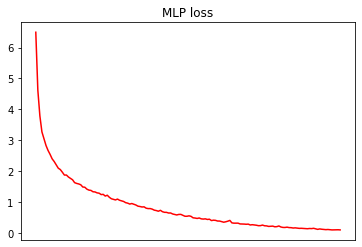

In [ ]:
plt.plot(range(len(MLP_loss)), MLP_loss, color='red')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off
plt.title('MLP loss')
plt.show()

In [ ]:
pred = network(X).detach().numpy()
print(pred.tolist())
print(Y.tolist())

[[0.13218902051448822], [24.361120223999023], [28.09644317626953], [22.13312530517578], [5.07505989074707], [5.902118682861328], [14.219452857971191], [13.655062675476074], [0.10452209413051605], [0.04465673863887787], [0.3024953603744507], [0.37655484676361084], [1.5924456119537354], [4.6161603927612305], [1.6863758563995361], [0.33260929584503174], [0.7700513601303101], [0.0635862797498703], [-0.08904840052127838], [0.2941683530807495], [0.08147846162319183], [-0.1524144560098648], [8.2975492477417], [5.02620792388916], [14.184480667114258], [6.311951637268066], [0.26860177516937256], [0.6202727556228638], [-0.04978765547275543], [-0.04479493200778961], [-0.2596852779388428], [0.818091630935669], [0.4117245674133301], [-0.2748754024505615], [2.518975019454956], [-0.04295004904270172], [0.009098276495933533], [0.3264601230621338], [-0.2191852480173111], [-0.5240861177444458], [0.40074050426483154], [1.2058285474777222], [0.14825616776943207], [0.7122374773025513], [0.10533539950847626

In [ ]:
data_path_2020 = os.path.join('/content/drive', 'My Drive', 'AFL', '2020_afl_stats.csv')
data_2020 = pd.read_csv(data_path_2020)

rounds = 23
round_key = {'R' + f"{i+1}": i for i in range(rounds)}
data_2020['Round'] = data_2020['Round'].replace(round_key) #test
print(data_2020['Round'].unique())

col1 = data.columns.tolist()[14:]
col2 = data_2020.columns.tolist()[5:]
col2.remove('Disp')
col2 = ['Disp'] + col2

add1 = ['Player','ID','Team','Opponent','Round',]

data_2020 = data_2020[add1 + col2]

colkey = {col2[i]:col1[i] for i in range(len(col1)) }

data_2020 = data_2020.rename(columns = colkey)

data_2020["Round"] =  pd.to_numeric(data_2020["Round"], errors = "coerce")


['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' 'QF' 'EF' 'SF' 'PF' 'GF']


In [ ]:

for n in data_2020['Player'].unique():
  if len(data_2020[data_2020['Player'] == n]['Team'].unique()) > 1:
    print(n)
    team1 = data_2020[data_2020['Player'] == n]['Team'].unique()[0]
    x = data_2020[(data_2020['Player'] == n) & (data_2020['Team'] == team1)]['Player'].replace(to_replace = n, value = n + '1')
    data_2020.update(x)
    print(data_2020.loc[(data_2020['Player'] == n) & (data_2020['Team'] == team1)]['Player'])

In [ ]:
X_test = []
Y_test = []

g2 = data_2020.groupby(by = ['Player'])
for df in tqdm(g2):

  Y_test.append(df[1]['BrownlowVotes'].agg(sum))
  X_test.append(transform_data(df[1]).values.flatten())





100%|██████████| 654/654 [00:17<00:00, 37.74it/s]


[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        10, 5, 4, 5, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 8, 0, 0, 4, 0, 0, 78,
        11, 5, 3, 6, 0, 0, 0, 1, 3, 1, 0, 6, 0, 2, 4, 6, 2, 0, 10, 2, 0,
        88, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 14, 9, 7, 5, 0, 0, 0, 4, 2, 2, 0, 2, 1, 0, 4, 9, 0, 0, 4, 0, 0,
        82, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 9, 5, 3, 4, 0, 0, 0, 1, 4, 0, 0, 0, 2, 0, 4, 5, 0, 0, 9, 0, 0,
        86, 10, 3, 2, 7, 0, 0, 0, 2, 1, 0, 0, 2, 1, 1, 4, 6, 0, 0, 2, 0, 0,
        86, 10, 6, 3, 4, 0, 0, 0, 3, 2, 1, 1, 4, 1, 1, 5, 7, 0, 0, 3, 0, 0,
        85, 13, 9, 4, 4, 0, 0, 0, 0, 4, 1, 0, 1, 0, 0, 1, 10, 0, 0, 11, 0,
        0, 98, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 2, 1, 0, 0,

In [ ]:
-pred

In [ ]:
X_test = torch.tensor(X_test, dtype=torch.float)
pred_2020 = network(X_test).detach().numpy()
print(pred_2020.tolist())
# print(Y.tolist())

[[-0.7949602007865906], [2.955320119857788], [0.8189977407455444], [0.7078138589859009], [0.17883239686489105], [0.14600186049938202], [0.7721835374832153], [0.22479163110256195], [-0.7607008218765259], [0.699588418006897], [-0.44257616996765137], [0.35031259059906006], [-0.5330002307891846], [1.5133697986602783], [-0.019237950444221497], [-0.9594748020172119], [2.7428903579711914], [-1.3201450109481812], [2.186479330062866], [1.103561282157898], [-0.19093729555606842], [1.3990381956100464], [0.7906550168991089], [-1.1850417852401733], [0.015982314944267273], [0.3537587523460388], [-0.28535860776901245], [0.2890512943267822], [-0.43011319637298584], [3.62593674659729], [-0.2868996858596802], [0.8692392110824585], [0.18951521813869476], [0.9463661909103394], [0.0026845186948776245], [-0.5351315140724182], [-0.484110951423645], [0.18039555847644806], [0.1318635493516922], [-0.08680148422718048], [-0.8079978227615356], [1.0840085744857788], [-0.37213897705078125], [-1.0135244131088257], [

In [ ]:
import heapq
best = heapq.nlargest(10, range(len(pred_2020)), pred_2020.__getitem__)

In [ ]:
g2

In [ ]:
from tabulate import tabulate
names_all = [i[0] for i in g2]
names = [names_all[i] for i in best]
vote = [pred_2020[i] for i in best]

print(len(vote), len(names))

tab = pd.DataFrame({'Player' :names,'Votes' : vote})
print(tabulate(tab, headers='keys', tablefmt='psql'))

10 10
+----+---------------------+---------+
|    | Player              |   Votes |
|----+---------------------+---------|
|  0 | Jack Macrae         | 8.92466 |
|  1 | Patrick Dangerfield | 8.47176 |
|  2 | Travis Boak         | 8.37097 |
|  3 | Ollie Wines         | 7.53164 |
|  4 | Patrick Cripps      | 5.84249 |
|  5 | Nat Fyfe            | 4.04951 |
|  6 | Todd Goldstein      | 3.75999 |
|  7 | Bailey Smith        | 3.62594 |
|  8 | David Mundy         | 3.5632  |
|  9 | Scott Pendlebury    | 3.38217 |
+----+---------------------+---------+
